#   **Agenda-based Search : AI Course Work One**
### **Student Id :** 211268
### **Student Name:** Kumar Sindhurakshit

In this part of the coursework agenda-based search  algorithms are implemented to find path between  two tube stations. 
Network of stations has been created from a CSV  data file file "tubedata.csv containg below details - 
* **StartingStation:** a starting station
* **EndingStation:** a directly connected ending station
* **TubeLine:** the tube line connecting the stations above
* **AverageTimeTaken:** the average time, in minutes, taken between the starting and the ending station
* **MainZone:** the main zone of the starting station
* **SecondaryZone:** the secondary zone of the starting station, which is 0 if the station is only in one zone. Note: to define the zone for the  ending station main zone is used if the secondary zone is 0 otherwise secondary zone is used .
## Organisation of Code
* **Section 1 :**  Reads CSV file and Creates Pandas Data Frame Object. 
* **Section 2 :**  Pandas Data Frame object is iteretated through to create a graph , as a function two visualise graph is implemented
* **Section 3 :**  Search algorithms including DFS, BFS , improved BFS , and Heuristic Seearch are implemented 
* **Section 4 :**  Above alogorithms are called with few source and destination to test and analyse algorithms 
* **Section 5 :**  Is creates small graph from test1.csv with similar structure with few nodes used for unit testing and visualization

***Note :**  Detailed map of London tube is available on  <a href=https://content.tfl.gov.uk/large-print-tube-map.pdf> Click here for London tube map</a>


## Section 1 : Read CSV file to pandas data frame

In [12]:
# Read csv file  to create data frame 
import pandas as pd
import time   # will used to analyse execution time for search algorithms 
def load_csv_file(file_name):
    df = pd.DataFrame()
    try:
        df = pd.read_csv(file_name, header=None)
        df.columns=['StartingStation','EndingStation','TubeLine', 'AverageTimeTaken', 'MainZone', 'SecondaryZone']
    except Exception as e:
        print("Unable  to load the file [{}], please ensure that file is available in current folder".format(file_name))
        print(e)
        
    return df


## Section 2 : Create networkx object and visualization graph 

In [13]:
# Section 2 A : Create Networks Graph from the Pandas data Frame
import networkx as nx
import matplotlib.pyplot as plt

def dataframe_to_graph(df):
    nxg=nx.Graph()
    df = df.reset_index()  # make sure indexes pair with number of rows
    for index, step in df.iterrows():
        nxg.add_node(step['StartingStation'], tube_line=step['TubeLine'], main_zone=step['MainZone'],secondary_zone = step['SecondaryZone'])
        if(step['SecondaryZone']==0):
            nxg.add_node(step['EndingStation'], tube_line=step['TubeLine'], main_zone=step['MainZone'],secondary_zone = step['SecondaryZone'])
        else:  # Use secondory Zone as Primary zone if secondory zone is not 0 for ending station
            nxg.add_node(step['EndingStation'], tube_line=step['TubeLine'], main_zone=step['SecondaryZone'],secondary_zone = step['SecondaryZone'])
        #Add edge between above two nodes    
        nxg.add_edge(step['StartingStation'], step['EndingStation'], weight=step['AverageTimeTaken'])
   
    return nxg  

# Section 2 B : This is visualisatio function for Networx graph
def show_weighted_graph(networkx_graph, node_size, font_size, fig_size):
  # Allocate the given fig_size in order to have space for each node
  plt.figure(num=None, figsize=fig_size, dpi=80)
  plt.axis('off')
  # Compute the position of each vertex in order to display it nicely
  nodes_position = nx.spring_layout(networkx_graph) 
  # You can change the different layouts depending on your graph
  # Extract the weights corresponding to each edge in the graph
  edges_weights  = nx.get_edge_attributes(networkx_graph,'weight')
  # Draw the nodes (you can change the color)
  nx.draw_networkx_nodes(networkx_graph, nodes_position, node_size=node_size,  
                         node_color = ["pink"]*networkx_graph.number_of_nodes())
  # Draw only the edges
  nx.draw_networkx_edges(networkx_graph, nodes_position, 
                         edgelist=list(networkx_graph.edges), width=2)
  # Add the weights
  nx.draw_networkx_edge_labels(networkx_graph, nodes_position, 
                               edge_labels = edges_weights)
  # Add the labels of the nodes
  nx.draw_networkx_labels(networkx_graph, nodes_position, font_size=font_size, 
                          font_family='sans-serif')
  plt.axis('off')
  plt.show()



## Section 3 : Implement search algorithms

### 3.1 Recursive DFS Serach Algorithm

In [14]:
def dfs_recursive_search(graph, origin, destination, already_visited = [], count=1, reverse=False):
  # If I reach destination, I finish right here, return list with the final place
  if origin == destination:
    return [origin], count+1
  
  next_already_visited = already_visited.copy()
  # Add current place to already_visited
  next_already_visited.append(origin)
  
  neighbours = reversed(list(graph.neighbors(origin))) if reverse else graph.neighbors(origin)
  # Check all possible destinations from where I am
  for next_node in neighbours:
    # Will only go if I havent gone before (No Loops nor going back)
    if next_node not in already_visited:
      # Go to first node possible
      result, count= dfs_recursive_search(graph, next_node, destination, next_already_visited, count, reverse)
      # If not dead end, means I found. Otherwise try next node
      if result != []:
        path = [origin] + result
        return path,count+1

  # If no node works, I return empty string which would mean dead end
  return [], count+1

In [ ]:
### 3.1 A Non-Recursive DFS Serach Algorithm

In [15]:
# Construct and return path from root to list of visted nodes
def construct_path_from_root(node, root):
    path_from_root = [node['label']]
    while node['parent']:
        node = node['parent']
        path_from_root = [node['label']] + path_from_root
    return path_from_root


def depth_first_graph_search(nxobject, initial, goal, max=200, compute_exploration_cost=True, reverse=False):
    frontier = [{'label':initial, 'parent':None}]  
    explored = {initial}
    number_of_explored_nodes = 1 

    while frontier:
        node = frontier.pop() # pop from the right of the list
        number_of_explored_nodes += 1
        if node['label']==goal:
            if compute_exploration_cost >max:   # exit if no of visted nodes have crossed threshold
                #print('number of explorations = {}'.format(number_of_explored_nodes))
                return None, number_of_explored_nodes
            return construct_path_from_root(node,initial), number_of_explored_nodes

        neighbours = reversed(list(nxobject.neighbors(node['label']))) if reverse else nxobject.neighbors(node['label'])
        
        for child_label in neighbours:

            child = {'label':child_label, 'parent':node}
            if child_label not in explored:
                frontier.append(child) # added to the right of the list, so it is a LIFO
                explored.add(child_label)
    return None , number_of_explored_nodes

### 3.2 BFS Serach Algorithm

In [16]:
def bfs_search_tree(graph, origin, destination, counter = 0, reverse=False):
  # Add current place to already_visited
  next_already_visited = [origin]
  # List of existent paths (for now only origin)
  total_paths = [[origin]] 

  # Will perform exploration of all current paths
  while len(total_paths)!= 0: 
    new_total_paths = []
    # I check every single existing path for now
    for path in total_paths:
        # Last element in path, where to go next?
        last_element_in_path = path[-1]
        # Nodes connected to here...
        nodes_found = list(reversed(list(graph.neighbors(last_element_in_path)))) if reverse else list(graph.neighbors(last_element_in_path))
        # Found destination
        if destination in nodes_found:
            # Result complete, will return this path with destination at end
            return path + [destination], counter+1 
        
        # Otherwise, I'll need to explore the nodes connected to here...
        for node in nodes_found:
          # I only will consider nodes not visited before (avoid loops and going back)
            if node not in next_already_visited:
                counter += 1
                # this node will be out of limits for next explorations
                next_already_visited.append(node)
                # I add this possible path for further exploration
                new_total_paths = new_total_paths + [path + [node]]
               # At the end, I need to explore only these "new" paths, until I reach destination, or run out of possible valid paths
        total_paths = new_total_paths

  # If no more possible paths, means solution does not exist
  return [],-1 -1

### 3.3 Uniform Cost Search

In [17]:
from queue import PriorityQueue

def get_path_cost(graph, path, weight='weight'):
    return nx.path_weight(graph, path, weight)

def uniform_cost_search(graph, origin, destination, counter = 0, reverse=False , debug=False):
    # Add current place to already_visited
    next_already_visited = [origin]
    # List of existent paths (for now only origin)
    total_paths = PriorityQueue() # Priority queue to ensure we get the lowest path cost first
    total_paths.put([0, [origin]]) # Root node with 0 cost
    
    # Will perform exploration of all current paths
    while total_paths.not_empty:
    
        new_total_paths = PriorityQueue()
        # I check every single existing path for now
        i=0
        while not total_paths.empty():
            # Last element in path, where to go next?
            i=i+1
            path= total_paths.get()
            #print("Path with cost-->", path)
            path=path[1]
            #print("Path {} -->{} and cost of the path: {}\n".format( i,path, get_path_cost(graph, path)))
            last_element_in_path = path[-1]
            #print("last_element_in_path-->",last_element_in_path)
             # Nodes connected to here...
            nodes_found = list(reversed(list(graph.neighbors(last_element_in_path)))) if reverse else list(graph.neighbors(last_element_in_path))
           # print("Negighours of {} are {} and original order was {}".format(last_element_in_path, nodes_found, list(graph.neighbors(last_element_in_path))))

            # Found destination
            if destination in nodes_found:
                # Result complete, will return this path with destination at end
                return path + [destination], counter+1
        
            # Otherwise, I'll need to explore the nodes connected to here...
            #before iterating through selected the node which edge have lowest cost first
            for node in nodes_found: 
                # I only will consider nodes not visited before (avoid loops and going back)
                if node not in next_already_visited:
                    counter += 1
                    # this node will be out of limits for next explorations
                    next_already_visited.append(node)
                    
                    # I add this possible path for further exploration
                    #new_total_paths = new_total_paths + [path + [node] ]
                    new_total_paths.put([get_path_cost(graph, path+[node]), path + [node]] )
                    #print("New Total Paths-->", new_total_paths)
                   # At the end, I need to explore only these "new" paths, until I reach destination, or run out of possible valid paths
            total_paths = new_total_paths
            
    # If no more possible paths, means solution does not exist
    return [],-1

### 3.4 Improved Uniform Cost Search

In [18]:
from queue import PriorityQueue

def get_path_cost_improved(graph, path, weight='weight', change_line_cost=2):
    start_time = time.time()
    ucs_cost=nx.path_weight(graph, path, weight)
    last_node_index=len(path)
    prev_tube_line=None
    transfer_cost=0
    #print("Improved Cost Path-->", path)
    for node in path:
        if(not (graph.nodes[node])):   #condition to check if zone data is present for the node
            cur_tube_line=None
        else:
            cur_tube_line=graph.nodes[node]['tube_line']
      
        #print("Node [{}] tube line-->[{}]".format(node,cur_tube_line))
        if(prev_tube_line !=None  and cur_tube_line!=prev_tube_line ):
            transfer_cost=transfer_cost+change_line_cost
        prev_tube_line =cur_tube_line
        #print("Node [{}] tube line-->[{}]  previous tube line[{}]".format(node,cur_tube_line, prev_tube_line) )
   
    return  ucs_cost+transfer_cost


def uniform_cost_search_improved(graph, origin, destination, counter = 0, reverse=False , add_line_change_cost=False):
    # Add current place to already_visited
    next_already_visited = [origin]
    # List of existent paths (for now only origin)
    total_paths = PriorityQueue() # Priority queue to ensure we get the lowest path cost first
    total_paths.put([0, [origin]]) # Root node with 0 cost
    
    # Will perform exploration of all current paths
    while total_paths.not_empty:
    
        new_total_paths = PriorityQueue()
        # I check every single existing path for now
        i=0
        while not total_paths.empty():
            # Last element in path, where to go next?
            i=i+1
            path= total_paths.get()
            #print("Path with cost-->", path)
            path=path[1]
            #print("Path {} -->{} and cost of the path: {}\n".format( i,path, get_path_cost(graph, path)))
            last_element_in_path = path[-1]
            #print("last_element_in_path-->",last_element_in_path)
             # Nodes connected to here...
            nodes_found = list(reversed(list(graph.neighbors(last_element_in_path)))) if reverse else list(graph.neighbors(last_element_in_path))
           # print("Negighours of {} are {} and original order was {}".format(last_element_in_path, nodes_found, list(graph.neighbors(last_element_in_path))))

            # Found destination
            if destination in nodes_found:
                # Result complete, will return this path with destination at end
                return path + [destination], counter+1
        
            # Otherwise, I'll need to explore the nodes connected to here...
            #before iterating through selected the node which edge have lowest cost first
            for node in nodes_found: 
                # I only will consider nodes not visited before (avoid loops and going back)
                if node not in next_already_visited:
                    counter += 1
                    # this node will be out of limits for next explorations
                    next_already_visited.append(node)
                    
                    # I add this possible path for further exploration
                    #new_total_paths = new_total_paths + [path + [node] ]
                    if (add_line_change_cost):
                        new_total_paths.put([get_path_cost_improved(graph, path+[node]), path + [node]] )
                    else:
                         new_total_paths.put([get_path_cost(graph, path+[node]), path + [node]] )
                        
                    #print("New Total Paths-->", new_total_paths)
                   # At the end, I need to explore only these "new" paths, until I reach destination, or run out of possible valid paths
            total_paths = new_total_paths
            
    # If no more possible paths, means solution does not exist
    return [],-1

### 3.5 Heruristic Search Based on zones

In [19]:
# Heuristics based on zones  , method is designed to include both UCS and heuristics 
# however changed it to return only heuristics cost based on discussion with teacher
''' Heuristics based on Zones, as price of the ticket depends on zones one is traveling we will apply 
additional cost if path goes in a zone which is either higher ot lower than source or desitnation zone
while we will no add any additional cost if the current zone of the station is in the range of zones of 
source and desitnations , for heuristics we are only considering primary zones
'''

def get_path_cost_improved_with_heuristics(graph, path, weight='weight', change_line_cost=2,min_zone=1, max_zone=1):
    ucs_cost=nx.path_weight(graph, path, weight)
    last_node_index=len(path)
    prev_tube_line=None
    transfer_cost=0
    heuristic_cost=0
    try:
        cur_zone=graph.nodes[path[-1]]['main_zone']
        if  cur_zone < min_zone or cur_zone>max_zone:
            heuristic_cost=10  # higher cost to avoid such transgration
    except :
        pass
    for node in path:
        if(not (graph.nodes[node])):   #condition to check if zone data is present for the node
            cur_tube_line=None
        else:
            cur_tube_line=graph.nodes[node]['tube_line']
      
        #print("Node [{}] tube line-->[{}]".format(node,cur_tube_line))
        if(prev_tube_line !=None  and cur_tube_line!=prev_tube_line ):
            transfer_cost=transfer_cost+change_line_cost
        prev_tube_line =cur_tube_line
        #print("Node [{}] tube line-->[{}]  previous tube line[{}]".format(node,cur_tube_line, prev_tube_line) )
   
    return  heuristic_cost  # based on discusion with teacher on heuristic cost,  ucs_cost + heuristic_cost

def uniform_cost_search_improved_with_heuristics(graph, origin, destination, counter = 0, reverse=False , add_line_change_cost=False):
    # Add current place to already_visited
    next_already_visited = [origin]
    # List of existent paths (for now only origin)
    total_paths = PriorityQueue() # Priority queue to ensure we get the lowest path cost first
    total_paths.put([0, [origin]]) # Root node with 0 cost
    try:
        source_zone=graph.nodes[origin]['main_zone']
        dest_zone = graph.nodes[destination]['main_zone']
        (min_zone, max_zone )= (source_zone , dest_zone )if source_zone< dest_zone else (source_zone , dest_zone)
    except:
        min_zone, max_zone=1,6
    print("Lowest Zone [{}] and Highest [{}] Highest Zone".format(min_zone, max_zone))
    # Will perform exploration of all current paths
    while total_paths.not_empty:
    
        new_total_paths = PriorityQueue()
        # I check every single existing path for now
        i=0
        while not total_paths.empty():
            # Last element in path, where to go next?
            i=i+1
            path= total_paths.get()
            #print("Path with cost-->", path)
            path=path[1]
            #print("Path {} -->{} and cost of the path: {}\n".format( i,path, get_path_cost(graph, path)))
            last_element_in_path = path[-1]
            #print("last_element_in_path-->",last_element_in_path)
             # Nodes connected to here...
            nodes_found = list(reversed(list(graph.neighbors(last_element_in_path)))) if reverse else list(graph.neighbors(last_element_in_path))
           # print("Negighours of {} are {} and original order was {}".format(last_element_in_path, nodes_found, list(graph.neighbors(last_element_in_path))))

            # Found destination
            if destination in nodes_found:
                # Result complete, will return this path with destination at end
                return path + [destination], counter+1
        
            # Otherwise, I'll need to explore the nodes connected to here...
            #before iterating through selected the node which edge have lowest cost first
            for node in nodes_found: 
                # I only will consider nodes not visited before (avoid loops and going back)
                if node not in next_already_visited:
                    counter += 1
                    # this node will be out of limits for next explorations
                    next_already_visited.append(node)
                    
                    # I add this possible path for further exploration
                    new_total_paths.put([get_path_cost_improved_with_heuristics(graph, path+[node], weight='weight', change_line_cost=3, min_zone=min_zone, max_zone=max_zone), path + [node]] )
                        
                    #print("New Total Paths-->", new_total_paths)
                   # At the end, I need to explore only these "new" paths, until I reach destination, or run out of possible valid paths
            total_paths = new_total_paths
            
    # If no more possible paths, means solution does not exist
    return [],-1

## 4 Test and analysis of algorithms
Routes used for comparison are - 
* Euston to Victoria
* Canada Water to Stratford
* New Cross Gate to Stepney Green
* Ealing Broadway to South Kensington
* Baker Street to Wembley Park
* Moor Park to Mile End

path in stations, cost in
average time, number of node expanded. The route from Euston to Victoria is a good one for testing.
Briefly describe how to launch the program and mention its main files in your report

BFS path between Euston and Victoria  is ['Euston', 'Warren Street', 'Oxford Circus', 'Green Park', 'Victoria'] Number of visited nodes 32 and exceution time 0.054 seconds
Cost of path return in BFS search: 7
UCS path between Euston and Victoria  is ['Euston', 'Warren Street', 'Oxford Circus', 'Green Park', 'Victoria']
Cost of path return in Uniform Cost search: 7
UCS path Improved between Euston and Victoria  is ['Euston', 'Warren Street', 'Oxford Circus', 'Green Park', 'Victoria']
Lowest Zone [1] and Highest [1] Highest Zone
Heuristic path between Euston and Victoria  is ['Euston', 'Warren Street', 'Oxford Circus', 'Green Park', 'Victoria']
DFS path between Euston and Victoria  is ['Euston', "King's Cross St. Pancras", 'Russell Square', 'Holborn', 'Covent Garden', 'Leicester Square', 'Piccadilly Circus', 'Green Park', 'Victoria']



BFS path between Canada Water and Stratford  is ['Canada Water', 'Canary Wharf', 'North Greenwich', 'Canning Town', 'West Ham', 'Stratford'] Number of vi

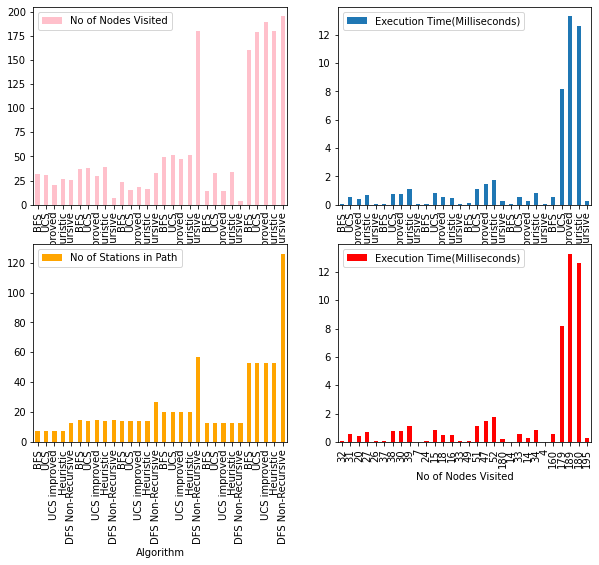

In [22]:
import matplotlib.pyplot as plt
analysis_df = pd.DataFrame(columns=['Algorithm', 'Starting Station', 'Ending Station', 'No of Nodes Visited', 'Execution Time(Milliseconds)', 'No of Stations in Path', 'Path'])


try:
    df = load_csv_file('tubedata.csv')
    graph=dataframe_to_graph(df)
    test_stations = [['Euston', 'Victoria'],['Canada Water', 'Stratford'], ['New Cross Gate','Stepney Green'],
                 ['Ealing Broadway', 'South Kensington'],['Baker Street', 'Wembley Park'],
                  ['Moor Park', 'Mile End']]
    row_count=0
    for test_pair in test_stations:
        row_count= row_count+1
        
        # BFS 
        start_time=time.time()
        bfs_path, no_of_visited_nodes = bfs_search_tree(graph, test_pair[0], test_pair[1])
        execution_time= (time.time()- start_time)*1000 # converting to millisecond
        analysis_df.loc [row_count]= [ "BFS", test_pair[0], test_pair[1], no_of_visited_nodes, round(execution_time,3), get_path_cost(graph, bfs_path), bfs_path]
        row_count= row_count+1
        print("BFS path between {} and {}  is {} Number of visited nodes {} and exceution time {:.3f} seconds".format(test_pair[0], test_pair[1], bfs_path, no_of_visited_nodes, execution_time))
        print("Cost of path return in BFS search:", get_path_cost(graph, bfs_path)) 
        
        #UCS
        start_time=time.time()
        ufcs_path,no_of_visited_nodes = uniform_cost_search(graph, test_pair[0], test_pair[1])
        execution_time= (time.time()- start_time)*1000 # converting to millisecond
        analysis_df.loc [row_count]= [ "UCS", test_pair[0], test_pair[1], no_of_visited_nodes, round(execution_time,3), get_path_cost(graph, ufcs_path), ufcs_path]
        row_count= row_count+1
        print("UCS path between {} and {}  is {}".format(test_pair[0], test_pair[1], ufcs_path))
        print("Cost of path return in Uniform Cost search:", get_path_cost(graph, ufcs_path))
 
        #UCS improved
        start_time=time.time()
        ufcs_path_improved, no_of_visited_nodes = uniform_cost_search_improved(graph, test_pair[0], test_pair[1], add_line_change_cost=True)
        execution_time= (time.time()- start_time)*1000 # converting to millisecond
        analysis_df.loc [row_count]= [ "UCS improved", test_pair[0], test_pair[1], no_of_visited_nodes, round(execution_time,3), get_path_cost(graph, ufcs_path_improved), ufcs_path_improved]
        row_count= row_count+1
        print("UCS path Improved between {} and {}  is {}".format(test_pair[0], test_pair[1], ufcs_path_improved))
        
        #Heuristics
        start_time=time.time()
        ufcs_path_heuristics, no_of_visited_nodes = uniform_cost_search_improved_with_heuristics(graph, test_pair[0], test_pair[1],True,True)
        execution_time= (time.time()- start_time)*1000 # converting to millisecond
        analysis_df.loc [row_count]= [ "Heuristic", test_pair[0], test_pair[1], no_of_visited_nodes, round(execution_time,3), get_path_cost(graph, ufcs_path_heuristics), ufcs_path_heuristics]
        row_count= row_count+1
        print("Heuristic path between {} and {}  is {}".format(test_pair[0], test_pair[1], ufcs_path_improved))
            
        if(   ufcs_path_improved != ufcs_path_heuristics):
            print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
            print("UCS and Heuristics Path are diffrent")
            print("UCS Path   [{}]  \nHeuristics Path [{}]".format(ufcs_path_improved , ufcs_path_heuristics))
            print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
        
        #start_time=time.time()
        #dfs_path, no_of_visited_nodes= dfs_recursive_search(graph, test_pair[0], test_pair[1])
        #execution_time= (time.time()- start_time)*1000 # converting to millisecond
        #analysis_df.loc [row_count]= [ "DFS", test_pair[0], test_pair[1], no_of_visited_nodes, round(execution_time,3), get_path_cost(graph, dfs_path), dfs_path]
        #row_count= row_count+1
        #print("DFS path between {} and {}  is {}\n".format(test_pair[0], test_pair[1], dfs_path))
        start_time=time.time()
        dfs_path, no_of_visited_nodes=depth_first_graph_search(graph, test_pair[0], test_pair[1] , 250)
        execution_time= (time.time()- start_time)*1000 # converting to millisecond
        analysis_df.loc [row_count]= [ "DFS Non-Recursive", test_pair[0], test_pair[1], no_of_visited_nodes, round(execution_time,3), get_path_cost(graph, dfs_path), dfs_path]
        row_count= row_count+1
        print("DFS path between {} and {}  is {}".format(test_pair[0], test_pair[1], dfs_path))


            
       
        print("\n\n")

    #show_weighted_graph(graph, 1000, 8,(20,60))
    #plt.show()
    fig = plt.figure(figsize=(10,8))
    # Divide the figure into a 2x2 grid, and give me the first section
    ax1 = fig.add_subplot(221)
    # Divide the figure into a 2x2 grid, and give me the second section
    ax2 = fig.add_subplot(222)
    # Divide the figure into a 2x2 grid, and give me the first section
    ax3 = fig.add_subplot(223)
    # Divide the figure into a 2x2 grid, and give me the second section
    ax4 = fig.add_subplot(224)
    analysis_df.to_csv("analysis.csv")
    analysis_df.plot(x ='Algorithm', y='No of Nodes Visited', kind = 'bar', color='pink', ax=ax1)
    analysis_df.plot(x ='Algorithm', y='Execution Time(Milliseconds)', kind = 'bar', ax=ax2)
    analysis_df.plot(x ='Algorithm', y='No of Stations in Path', kind = 'bar', color='orange', ax=ax3)
    analysis_df.plot(x ='No of Nodes Visited', y='Execution Time(Milliseconds)', kind = 'bar', color='red', ax=ax4)

    plt.show()

    #print(analysis_df, sep='\n')
except Exception as e:
    print(e)


## 5 Unit testing with graph having few nodes

DFS Path--> ['A', 'B', 'D']


 BFS Path --> ['A', 'B', 'D']


Uniform Cost Path --> ['A', 'E', 'F', 'D']
9
34
Uniform Improved Cost Path --> ['A', 'E', 'F', 'D']


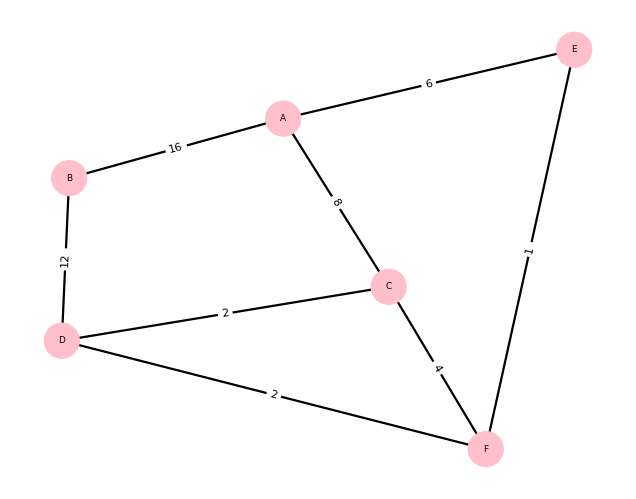

In [21]:
import matplotlib.pyplot as plt

try:
    #test_df = pd.read_csv('test.csv', header=None)
    test_df = load_csv_file('test1.csv')
    graph=dataframe_to_graph(test_df)
    dfs_path, _ = dfs_recursive_search(graph, 'A', 'D')
    print("DFS Path-->", dfs_path)
    bfs_path, _ = bfs_search_tree(graph, 'A', 'D')
    print("\n\n BFS Path -->",bfs_path)
    print("\n")
    ufcs_path, _ = uniform_cost_search(graph, 'A', 'D',reverse=True)
    print("Uniform Cost Path -->",ufcs_path)
    print(get_path_cost(graph,ufcs_path))
    print(get_path_cost(graph,['A', 'B', 'D', 'C','F']))
    uniform_cost_search_improved
    ufcs_path_improved, _ = uniform_cost_search_improved(graph, 'A', 'D',reverse=True)
    print("Uniform Improved Cost Path -->",ufcs_path_improved)
    show_weighted_graph(graph, 1000, 8,(10,8))
    plt.show()
except Exception as e:
    print(e)